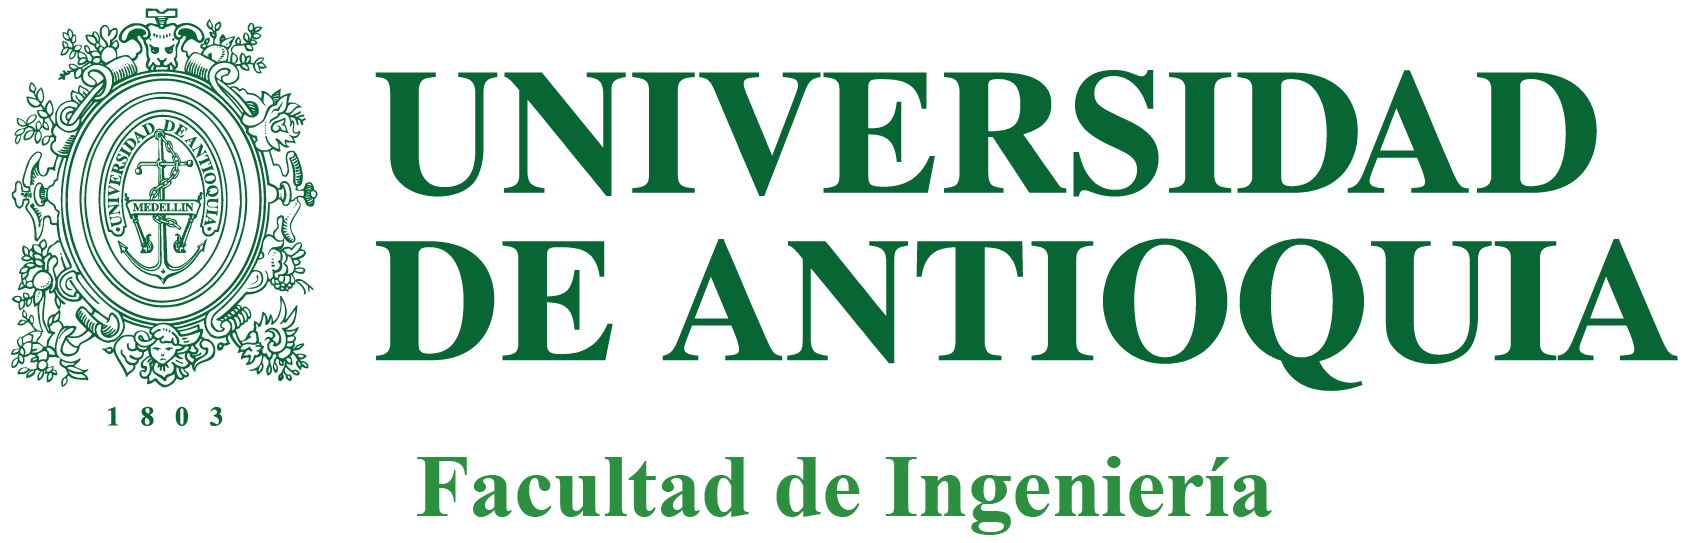
---
- **Asignatura:** Tratamiento de Señales III
- **Profesor:** Hernán Felipe García Arias
- **Ingeniería de Telecomunicaciones**
- **UdeA**
- **2023-2**

---

- Santiago Torres Velásquez
- Santiago Narváez Toro

In [1]:
# Librerías para la ejecución del notebook

import os,random
import numpy as np
import pickle, sys
import seaborn as sns
import tensorflow as tf
import matplotlib.pyplot as plt
import tensorflow.keras.models as models
from tensorflow.keras.layers import Conv2D

from tensorflow import keras
from keras.utils import to_categorical
from tensorflow.keras.regularizers import *
from sklearn.preprocessing import LabelBinarizer
from tensorflow.keras.layers import GaussianNoise
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
from tensorflow.keras.layers import Reshape,Dense,Dropout,Activation,Flatten
from tensorflow.keras.layers import Convolution2D, MaxPooling2D, ZeroPadding2D

%matplotlib inline

In [2]:
# Descarga de los datos
!gdown '1Yuj_rq3EEITslOQ0AHEl2HKzDovMQH3K'

Downloading...
From: https://drive.google.com/uc?id=1Yuj_rq3EEITslOQ0AHEl2HKzDovMQH3K
To: /content/RML2016.10a_dict.pkl
100% 641M/641M [00:08<00:00, 75.1MB/s]


In [3]:
# Cargar el dataset
with open("RML2016.10a_dict.pkl", 'rb') as f:
    Xd = pickle.load(f, encoding="latin1")

# Calculate modulations and signal-to-noise ratios contained in dataset.
# Calcular las modulationes y las relaciones señal a ruido contenidas en los datos.
snrs,mods = map(lambda j: sorted(list(set(map(lambda x: x[j], Xd.keys())))), [1,0])

print('Modulaciones presentes en el dataset: {}'.format(mods))
print('Relaciones señal a ruido en el dataset: {}'.format(snrs))

Modulaciones presentes en el dataset: ['8PSK', 'AM-DSB', 'AM-SSB', 'BPSK', 'CPFSK', 'GFSK', 'PAM4', 'QAM16', 'QAM64', 'QPSK', 'WBFM']
Relaciones señal a ruido en el dataset: [-20, -18, -16, -14, -12, -10, -8, -6, -4, -2, 0, 2, 4, 6, 8, 10, 12, 14, 16, 18]


In [4]:
np.shape(Xd['BPSK', -18])

(1000, 2, 128)

+ La primera dimensión representa las 1,000 ventanas muestreadas (cada ventana tiene las 128 muestras de I y Q).
+ La segunda dimensión representa los dos componentes (I y Q) de la señal de radiofrecuencia.
+ La tercera dimensión representa las 128 muestras en el tiempo (1 MHz, por lo que 1 $\mu$s por índice).

Este "shape" puede realizarse para cualquier dupla de valores ('Tipo de modulación', 'relación señal a ruido')


In [5]:
# Función que permite reconstruir la señal en el dominiot del tiempo
def reconstructSignal(s):
    I = s[0,:]   # I component
    Q = s[1,:]   # Q component
    n = len(I)   # number of samples
    f = 1e6     # Carrier frequency
    return I*np.cos(2*np.pi*f*np.arange(n)) + Q*np.sin(2*np.pi*f*np.arange(n))

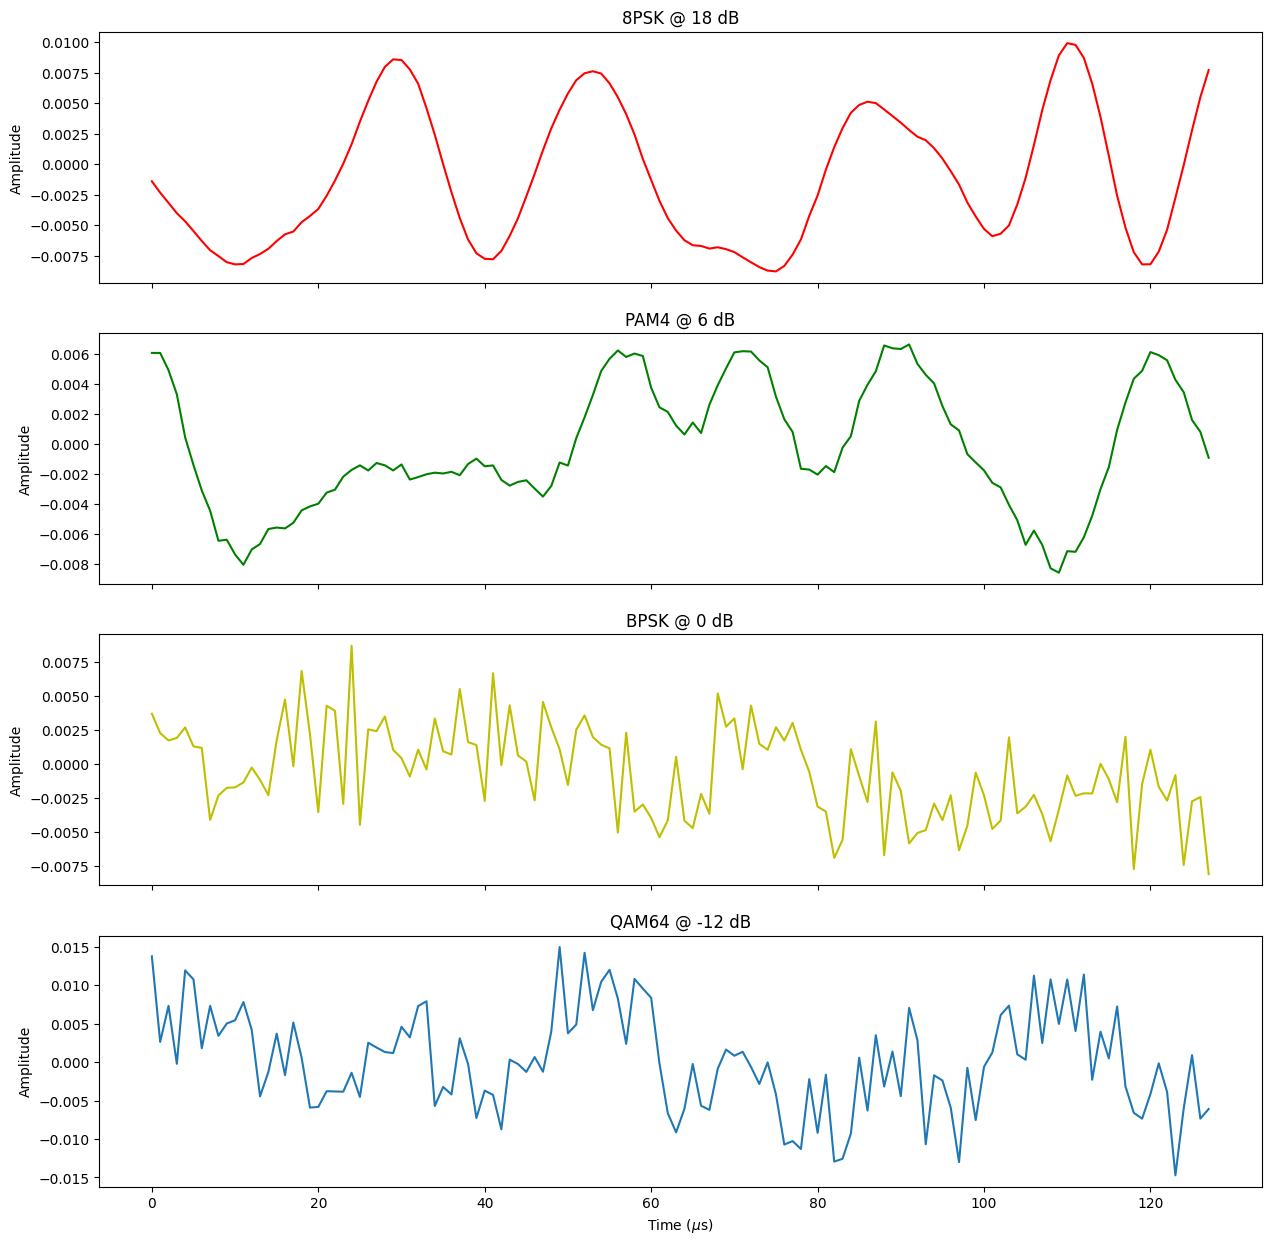

In [6]:
# Plot some of the data
nFigs = 4

plt.figure(figsize=(15, 15))

ax1 = plt.subplot(nFigs, 1, 1);
plt.plot(reconstructSignal(Xd['8PSK', 18][2,:,:]), color='r');
plt.title('8PSK @ 18 dB')
plt.ylabel('Amplitude');

ax2 = plt.subplot(nFigs, 1, 2, sharex=ax1);
plt.plot(reconstructSignal(Xd['PAM4', 6][99,:,:]), color='g');
plt.title('PAM4 @ 6 dB')
plt.ylabel('Amplitude');

ax3 = plt.subplot(nFigs, 1, 3, sharex=ax1)
plt.plot(reconstructSignal(Xd['BPSK', 0][456,:,:]), color='y');
plt.title('BPSK @ 0 dB')
plt.ylabel('Amplitude');

ax4 = plt.subplot(nFigs, 1, 4, sharex=ax1)
plt.plot(reconstructSignal(Xd['QAM64', -12][32,:,:]));
plt.title('QAM64 @ -12 dB')
plt.ylabel('Amplitude');

# We only need to show the xticks on the bottom subplot
plt.setp(ax3.get_xticklabels(), visible=False)
plt.setp(ax2.get_xticklabels(), visible=False)
plt.setp(ax1.get_xticklabels(), visible=False)

plt.xlabel(r'Time ($\mu$s)');

## Ahora necesitamos concatenar todas las modulaciones, relaciones señal-ruido (SNR), muestras, canales y puntos temporales en una única matriz grande para pasarla a nuestra red neuronal.

Habrá 220000 muestras. Cada muestra es de tamaño 2 x 128. Los 2 corresponden a los canales I y Q. Los 128 son las 128 muestras temporales de la forma de onda (muestreadas a 1 MHz).

El tamaño de la matriz corresponde a la cantidad de modulaciones y SNR presentes en los datos:

+ Modulaciones = 11
+ SNR's = 20
+ Muestras por cada pareja de datos = 1000

Finalmente el total de muestras en la matriz será de $11*20*1000 = 220000$ muestras.

In [7]:
snrs,mods = map(lambda j: sorted(list(set(map(lambda x: x[j], Xd.keys())))), [1,0])
X = []
lbl = []
for mod in mods:
    for snr in snrs:
        X.append(Xd[(mod,snr)])
        for i in range(Xd[(mod,snr)].shape[0]):  lbl.append((mod,snr))
X = np.vstack(X)

# Verificar la dimensionalidad de la matriz.
np.shape(X)

(220000, 2, 128)

## Añadir ruido al conjunto de datos

La idea es agregar 2 canales de ruido gaussiano aleatorio para brindarle a la red la opción de elegir si no puede decidir entre las verdaderas modulaciones. Básicamente, esto es una clasificación de "I don't know".

In [8]:
numNoiseSamples = 20000 # 20000 muestras de ruido gaussiano
for i in range(numNoiseSamples):
    lbl.append(['Noise', snrs[i%len(snrs)]])

mods.append('Noise')
X_noise = np.random.normal(0, 0.01, [numNoiseSamples, 2, 128])
X = np.concatenate((X, X_noise))  # Añadir ruido al final de los datos

## El primer paso es realizar una codificación One Hot para codificar los nombres de las modulaciones y que sea entendible por el computador en términos de números.

In [9]:
lbl = np.array(lbl) # Convertir de lista a numpy array

y_encoded = LabelBinarizer().fit_transform(lbl[:,0])

print(y_encoded.shape)

(240000, 12)


In [10]:
# Se verifica el funcionamiento de la codificación
y_encoded[-10:]

array([[0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0]])

## Dividir los datos en entrenamiento y test.


In [11]:
np.random.seed(2016)
n_examples = X.shape[0]
n_train = int(n_examples * 0.7)

# Ahora obtenemos una lista de índices aleatorios para muestrear el conjunto de entrenamiento
train_idx = np.random.choice(range(0,n_examples), size=n_train, replace=False)

# El conjunto de prueba se forma con los demás índices.
test_idx = list(set(range(0,n_examples))-set(train_idx))

# Dividir los datos según los índices
X_train = X[train_idx]

X_train = X_train[10000:]
X_test =  X[test_idx]
X_validation = X_train[:10000]

Y_train = y_encoded[train_idx]

Y_train = Y_train[10000:]
Y_test = y_encoded[test_idx]
Y_validation = Y_train[:10000]

print('Dimensionalidad de los datos de entrenamiento {}'.format(np.shape(X_train)))
print('Dimensionalidad de los datos de test {}'.format(np.shape(X_test)))
print('Dimensionalidad de los datos de validación {}'.format(np.shape(X_validation)))


Dimensionalidad de los datos de entrenamiento (158000, 2, 128)
Dimensionalidad de los datos de test (72000, 2, 128)
Dimensionalidad de los datos de validación (10000, 2, 128)


In [12]:
# Se aprecia el ruido agregado y la dimensionalidad de los datos de entrenamiento
in_shp = list(X_train.shape[1:])
print(X_train.shape, in_shp)
classes = mods
print(classes)

(158000, 2, 128) [2, 128]
['8PSK', 'AM-DSB', 'AM-SSB', 'BPSK', 'CPFSK', 'GFSK', 'PAM4', 'QAM16', 'QAM64', 'QPSK', 'WBFM', 'Noise']


# Build the NN Model

Your task here is to code 2 CNN architectures to assess modulation recognition using Deep Learning Approaches

In [13]:
dr = 0.6 # dropout rate (%) = percentage of neurons to randomly lose each iteration
model = models.Sequential()  # Neural network is a set of sequential layers
w, h = 2, 128

# Reshape [N,2,128] to [N,2,128,1] on input
X_train_reshaped = X_train.reshape(X_train.shape[0], w, h, 1)
X_test_reshaped = X_test.reshape(X_test.shape[0], w, h, 1)
X_validation_reshaped = X_validation.reshape(X_validation.shape[0], w, h, 1)

model.add(Reshape((w,h,1), input_shape=(w,h)))

# Pass through 3 2DConv/ReLu layers
model.add(Convolution2D(filters=32, kernel_size=(1,6), padding='same', activation='relu', input_shape=(w,h,1)))
model.add(Convolution2D(filters=64, kernel_size=(1,6), padding='same', activation='relu'))
model.add(Convolution2D(filters=128, kernel_size=(1,6), padding='same', activation='relu'))

# Flatten layer
model.add(Flatten())

# 2 Dense layers (ReLu and Softmax)
model.add(Dense(512, activation='relu'))
model.add(Dropout(dr))

model.add(Dense(12, activation='softmax'))

# Display the model summary
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 reshape (Reshape)           (None, 2, 128, 1)         0         
                                                                 
 conv2d (Conv2D)             (None, 2, 128, 32)        224       
                                                                 
 conv2d_1 (Conv2D)           (None, 2, 128, 64)        12352     
                                                                 
 conv2d_2 (Conv2D)           (None, 2, 128, 128)       49280     
                                                                 
 flatten (Flatten)           (None, 32768)             0         
                                                                 
 dense (Dense)               (None, 512)               16777728  
                                                                 
 dropout (Dropout)           (None, 512)               0

In [14]:
# Compilar el modelo con categorical_crossentropy
model.compile(loss='categorical_crossentropy',
             optimizer='adam',
             metrics=['accuracy'])

In [15]:
# Set up some params
nb_epoch = 100     # number of epochs to train on
batch_size = 1024  # training batch size

# Train the Model

For the model training, please use `ModelCheckpoint` and `EarlyStopping` to monitor training and avoid overfitting

In [16]:
# perform training ...
#   - call the main training loop in keras for our network+dataset
filepath = './'
modelWeightsFile = filepath + 'PESOS_TSIII.wts.h5'  # Save the model weights to this file

history = model.fit(X_train,
    Y_train,
    batch_size=batch_size,
    epochs=nb_epoch,
    verbose=2,
    validation_data=(X_test, Y_test),
    callbacks = [
        keras.callbacks.ModelCheckpoint(modelWeightsFile, monitor='val_loss', verbose=1, save_best_only=True, mode='auto'),
        keras.callbacks.EarlyStopping(monitor='val_loss', patience=10, verbose=1, mode='auto')
    ])

# we re-load the best weights once training is finished
model.load_weights(modelWeightsFile)

Epoch 1/100

Epoch 1: val_loss improved from inf to 1.67834, saving model to ./PESOS_TSIII.wts.h5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


155/155 - 26s - loss: 1.9928 - accuracy: 0.2770 - val_loss: 1.6783 - val_accuracy: 0.3836 - 26s/epoch - 170ms/step
Epoch 2/100

Epoch 2: val_loss improved from 1.67834 to 1.39450, saving model to ./PESOS_TSIII.wts.h5
155/155 - 13s - loss: 1.5607 - accuracy: 0.4173 - val_loss: 1.3945 - val_accuracy: 0.4848 - 13s/epoch - 85ms/step
Epoch 3/100

Epoch 3: val_loss improved from 1.39450 to 1.32160, saving model to ./PESOS_TSIII.wts.h5
155/155 - 13s - loss: 1.4221 - accuracy: 0.4664 - val_loss: 1.3216 - val_accuracy: 0.4964 - 13s/epoch - 85ms/step
Epoch 4/100

Epoch 4: val_loss improved from 1.32160 to 1.29033, saving model to ./PESOS_TSIII.wts.h5
155/155 - 14s - loss: 1.3715 - accuracy: 0.4842 - val_loss: 1.2903 - val_accuracy: 0.5131 - 14s/epoch - 91ms/step
Epoch 5/100

Epoch 5: val_loss did not improve from 1.29033
155/155 - 13s - loss: 1.3334 - accuracy: 0.4967 - val_loss: 1.2987 - val_accuracy: 0.5077 - 13s/epoch - 83ms/step
Epoch 6/100

Epoch 6: val_loss improved from 1.29033 to 1.25010

# Evaluate and Plot Model Performance

In [17]:
y_predict = model.predict(X_test, batch_size=batch_size)
print(classification_report(np.argmax(Y_test, axis=1), np.argmax(y_predict, axis=1)))

71/71 [==============================] - 2s 25ms/step
              precision    recall  f1-score   support

           0       0.48      0.52      0.50      5957
           1       0.55      0.65      0.60      5852
           2       0.27      0.89      0.42      5932
           3       0.81      0.57      0.67      6051
           4       0.78      0.61      0.68      5963
           5       0.76      0.64      0.70      6022
           6       1.00      1.00      1.00      6125
           7       0.89      0.64      0.74      5991
           8       0.45      0.29      0.35      5906
           9       0.54      0.48      0.51      6029
          10       0.66      0.40      0.50      6072
          11       0.65      0.24      0.36      6100

    accuracy                           0.58     72000
   macro avg       0.65      0.58      0.59     72000
weighted avg       0.66      0.58      0.59     72000



## Loss curves

Loss curves show us how well the training went. They also allow us to detect over-training of the model. If the model is over-trained, then it might not generalize well. Often, in an over-trained model, the training loss (error) will continually decrease while the validation (test error) will decrease and then begin to increase again with successive training epochs.

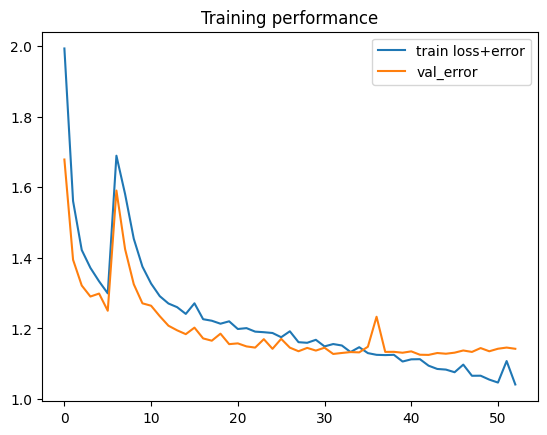

In [18]:
# Show loss curves
plt.figure();
plt.title('Training performance');
plt.plot(history.epoch, history.history['loss'], label='train loss+error');
plt.plot(history.epoch, history.history['val_loss'], label='val_error');
plt.legend();

# Confusion Matrix

A confusion matrix is a great way to see where the model (neural network) had trouble. It plots the number of times the model predicted a modulation versus the actual modulation (predicted versus true).

In [19]:
def plot_confusion_matrix(cm, title='Confusion matrix', cmap=plt.cm.Blues, labels=[]):
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(labels))
    plt.xticks(tick_marks, labels, rotation=45)
    plt.yticks(tick_marks, labels)
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

71/71 [==============================] - 2s 25ms/step


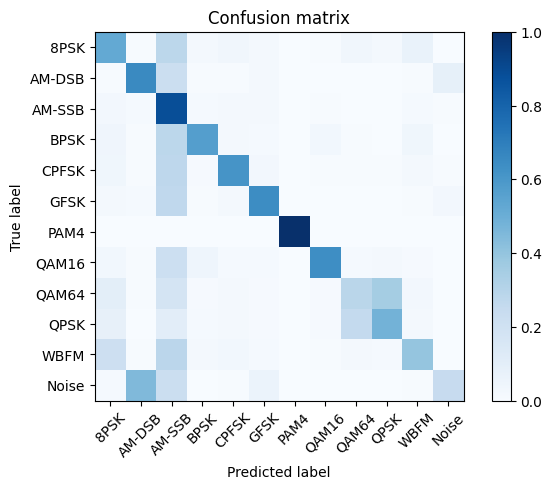

In [20]:
# Plot confusion matrix
test_Y_hat = model.predict(X_test, batch_size=batch_size)
conf = np.zeros([len(classes),len(classes)])
confnorm = np.zeros([len(classes),len(classes)])
for i in range(0,X_test.shape[0]):
    j = list(Y_test[i,:]).index(1)
    k = int(np.argmax(test_Y_hat[i,:]))
    conf[j,k] = conf[j,k] + 1
for i in range(0,len(classes)):
    confnorm[i,:] = conf[i,:] / np.sum(conf[i,:])
plot_confusion_matrix(confnorm, labels=classes)



Pleaes evaluate the model in terms of $SNR$ and their accuracy for each modulation (below is a a sample code to assess your models)

112/112 [==============================] - 1s 3ms/step
Overall Accuracy for SNR -20: 0.17239452360994692
113/113 [==============================] - 0s 2ms/step
Overall Accuracy for SNR -18: 0.1728053170866796
115/115 [==============================] - 0s 3ms/step
Overall Accuracy for SNR -16: 0.17245148947799946
114/114 [==============================] - 0s 3ms/step
Overall Accuracy for SNR -14: 0.18736203090507728
115/115 [==============================] - 0s 2ms/step
Overall Accuracy for SNR -12: 0.2187842278203724
116/116 [==============================] - 0s 3ms/step
Overall Accuracy for SNR -10: 0.27943570265870865
111/111 [==============================] - 0s 3ms/step
Overall Accuracy for SNR -8: 0.4136273678258411
112/112 [==============================] - 0s 3ms/step
Overall Accuracy for SNR -6: 0.5505177721802407
112/112 [==============================] - 0s 2ms/step
Overall Accuracy for SNR -4: 0.6368964554842311
114/114 [==============================] - 0s 3ms/step
Overall 

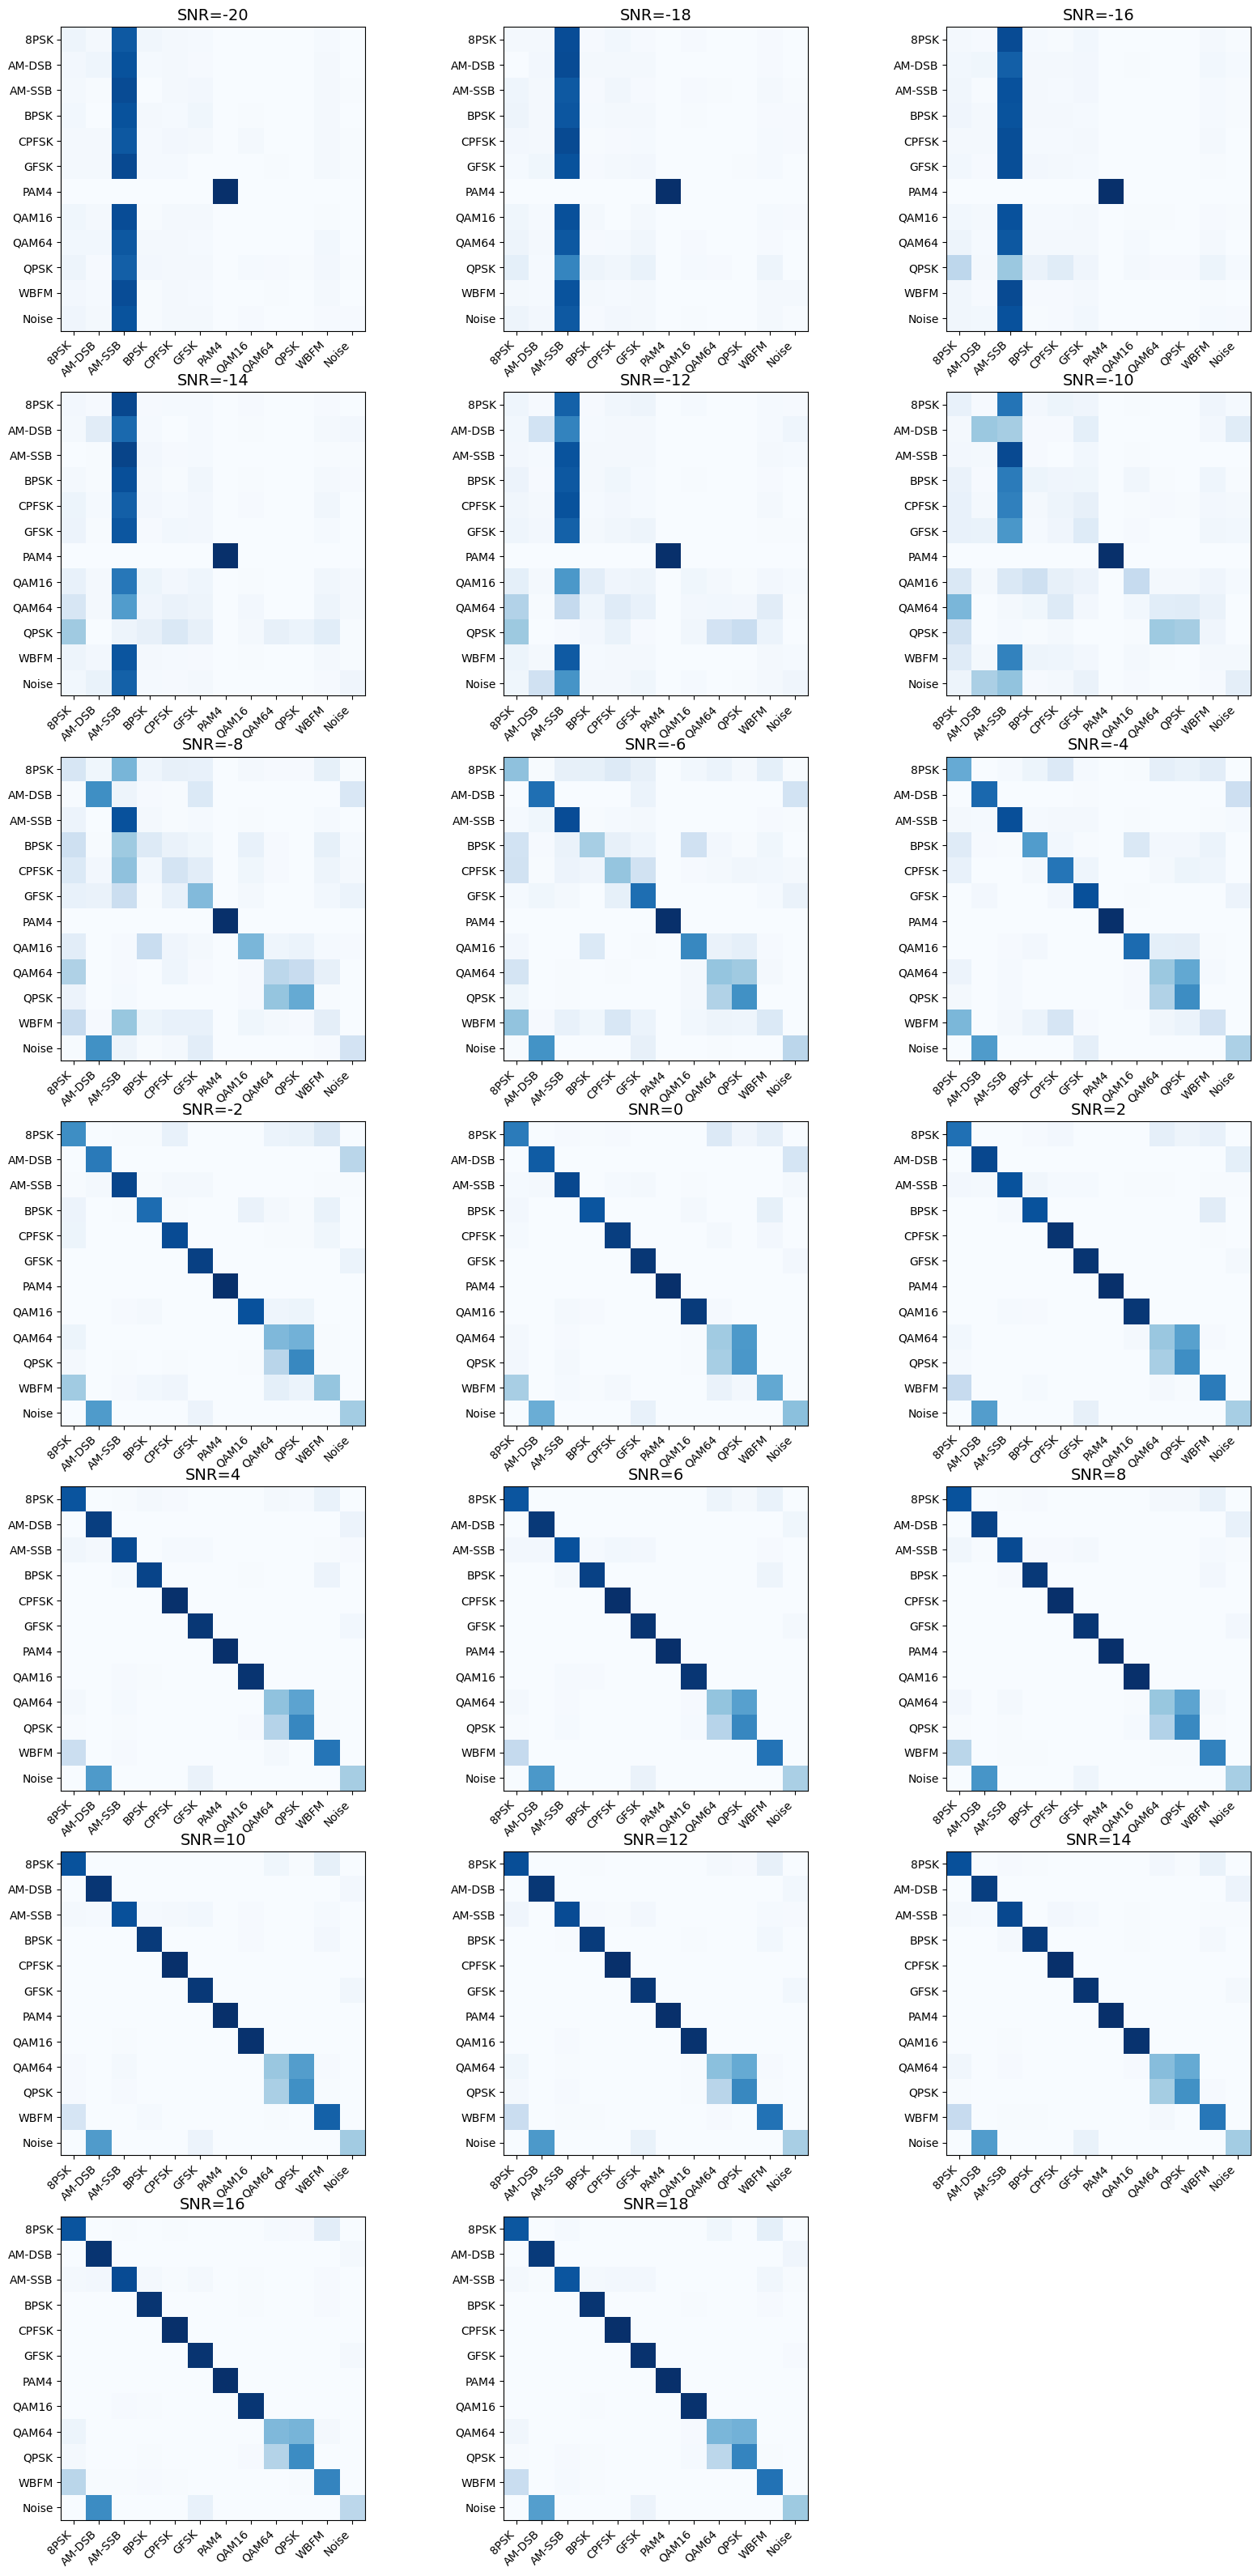

In [21]:
import matplotlib.pyplot as plt
import numpy as np

# Definir el número de filas y columnas
num_filas = 7
num_columnas = 3
acc = {}

# Ajustar el tamaño de los subgráficos
fig, axs = plt.subplots(num_filas, num_columnas, figsize=(20, 40))

# Iterar sobre las relaciones SNR y crear un subplot para cada una
for i, snr in enumerate(snrs):
    # extract classes @ SNR
    test_SNRs = map(lambda x: int(lbl[x][1]), test_idx)
    aux_vector = np.array(list(test_SNRs))
    test_X_i = X_test[np.where(aux_vector == snr)]
    test_Y_i = Y_test[np.where(aux_vector == snr)]

    # Check if there are data samples for the current SNR
    if len(test_X_i) == 0:
        print("No data samples available for SNR: {}".format(snr))
        continue

    # estimate classes
    test_Y_i_hat = model.predict(test_X_i)
    conf = np.zeros([len(classes), len(classes)])
    confnorm = np.zeros([len(classes), len(classes)])

    for j in range(0, test_X_i.shape[0]):
        true_label = list(test_Y_i[j, :]).index(1)
        predicted_label = int(np.argmax(test_Y_i_hat[j, :]))
        conf[true_label, predicted_label] += 1

    for j in range(0, len(classes)):
        confnorm[j, :] = conf[j, :] / np.sum(conf[j, :])

    # Obtener la posición del subplot en la matriz de subgráficos
    fila_actual = i // num_columnas
    columna_actual = i % num_columnas

    # Crear un subplot y mostrar la matriz de confusión en ese subplot
    im = axs[fila_actual, columna_actual].imshow(confnorm, interpolation='nearest', cmap=plt.cm.Blues)
    axs[fila_actual, columna_actual].set_title("SNR={}".format(snr), fontsize=14)
    axs[fila_actual, columna_actual].set_xticks(np.arange(len(classes)))
    axs[fila_actual, columna_actual].set_yticks(np.arange(len(classes)))
    axs[fila_actual, columna_actual].set_xticklabels(classes, fontsize=10, rotation=45, ha="right")  # Añadir rotation y ha
    axs[fila_actual, columna_actual].set_yticklabels(classes, fontsize=10)

    cor = np.sum(np.diag(conf))
    ncor = np.sum(conf) - cor
    print("Overall Accuracy for SNR {}: {}".format(snr, cor / (cor+ncor)))
    acc[snr] = 1.0*cor/(cor+ncor)

# Eliminar el último subplot
fig.delaxes(axs[-1, -1])

# Mostrar los subgráficos
plt.show()


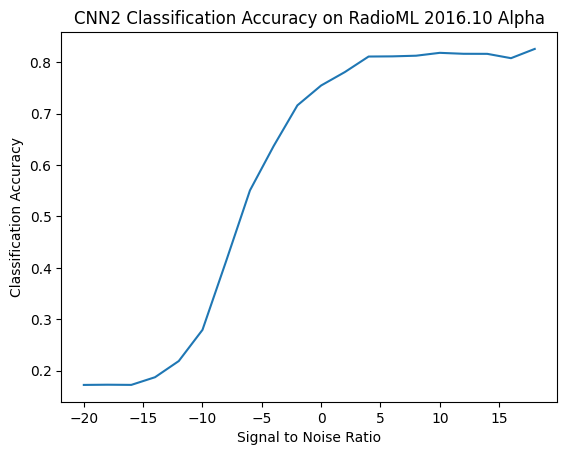

In [22]:
accuracy_values = [acc[snr] for snr in snrs]

plt.plot(snrs, accuracy_values)

plt.xlabel("Signal to Noise Ratio");
plt.ylabel("Classification Accuracy");
plt.title("CNN2 Classification Accuracy on RadioML 2016.10 Alpha");
plt.show()

## Final Project Assignment: Modulation Recognition Using Convolutional Neural Networks (CNN) with Database


**Objective:**
- The objective of this final project is to design and implement a modulation recognition system using Convolutional Neural Networks (CNN). The project will involve building a robust CNN model capable of accurately classifying different modulation schemes present in the provided database (RadioML2016). Modulation recognition is a crucial task in wireless communication systems, and your implementation will contribute to the advancement of signal processing in communications.

**Dataset:**
- You will be provided with a dataset (Database RadioML2016) containing samples of signals with various modulation schemes. The dataset is divided into training and testing sets. It is essential to preprocess the data appropriately to feed it into the CNN model.

**Tasks:**

1. Data Preprocessing: Load and explore the dataset to understand its structure and characteristics.
Preprocess the data, including normalization, resizing, and any other necessary steps to prepare it for input into the CNN.
2. CNN Model Architecture:
Design a CNN architecture suitable for modulation recognition. Consider the input shape, number of layers, filter sizes, and activation functions.
Implement the CNN model using a deep learning framework of your choice (e.g., TensorFlow, PyTorch, Keras).
3. Training: Split the dataset into training and validation sets.
Train the CNN model using the training set, monitoring and optimizing for performance on the validation set.
Experiment with different hyperparameters to enhance the model's accuracy.
4. Evaluation: Evaluate the trained model on the testing set to assess its performance in recognizing modulation schemes.
Calculate relevant metrics such as accuracy, precision, recall, and F1 score.
5. Analysis and Visualization: Provide visualizations of the training/validation loss and accuracy over epochs.
Analyze the confusion matrix to understand the model's performance on different modulation schemes.
6. Documentation: Prepare a comprehensive notebook report documenting the entire project, including data exploration, model architecture, training process, evaluation results, and analysis. Include code documentation and comments for clarity.
7. Presentation: Prepare a pitch presentation summarizing key aspects of your project.
Present the motivation, methodology, results, and any challenges faced during the implementation.
8. Submission Guidelines: Submit the project code along with a README file providing instructions on how to run the code (use GIT).
9. Submit the project report in a clear and organized format on GIT repo.
10. Ensure that your implementation is well-documented, and your code follows best practices.


*This final project will not only test your understanding of modulation recognition and CNNs but also your ability to apply machine learning concepts to real-world signal processing challenges.*

Good luck!







-